## Es1

In [28]:
triang <- function(x,a,b,c) {
    if(a>b){return("Not valid input")}
    ifelse(x>=a & x < c, 
        2*(x-a)/( (b-a)*(c-a) ),
        ifelse(x>=c & x<=b,
        2*(b-x)/( (b-a)*(b-c)  ), 
        0)
    )
}

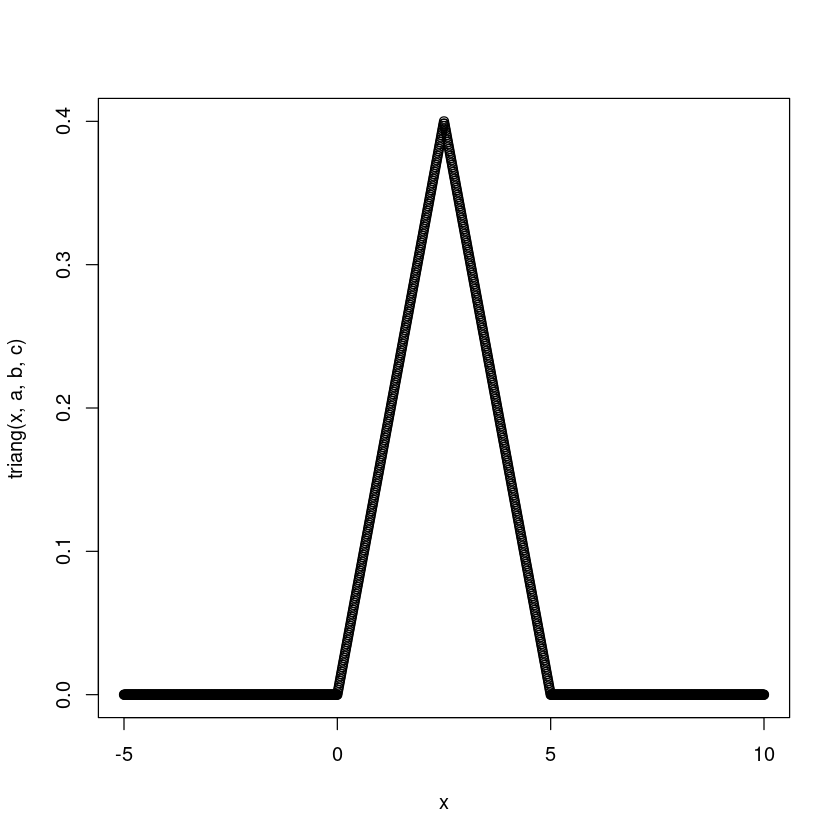

In [70]:
a <- 0
b <- 5
c <- (a+b)/2
x <- seq(a-5, b+5, 0.01)
plot(x, triang(x,a,b,c))

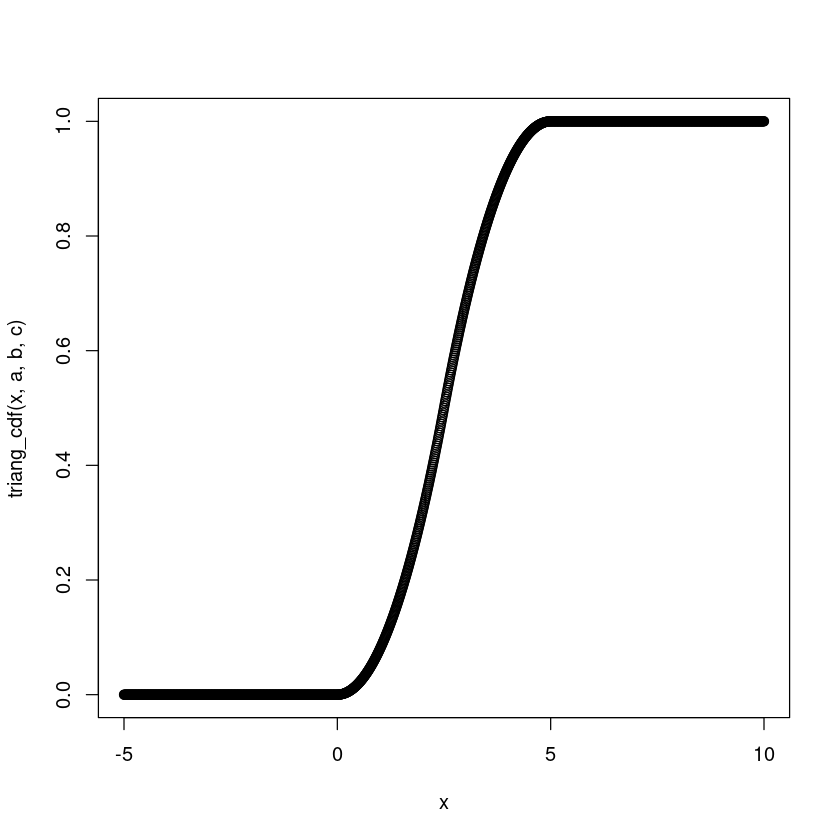

In [71]:
#how to generate random numbers from a continuous distribution
N <- 100
#integrating by hand the triangular pdf
triang_cdf <- function(x,a,b,c){
    if(a>b){return("Not valid input")}
    A <- 2/((b-a)*(c-a)) 
    B <- 2/((b-a)*(b-c))
    ifelse(x<a, 0,
        ifelse(x>=a & x < c,
        (0.5* x^2 - a*x + 0.5* a^2) * A,
        ifelse(x>=c & x<=b,
        (b*x - 0.5*x^2 -b*c + 0.5*c^2) * B + (0.5* c^2 - a*c + 0.5* a^2) * A, #this traslational term is due to interval definition function
        1)
    ) )
}


plot(x, triang_cdf(x,a,b,c))


The function is invertible only in the interval [a,b] obviously

[1] 0

[1] 1

[1] 0.5

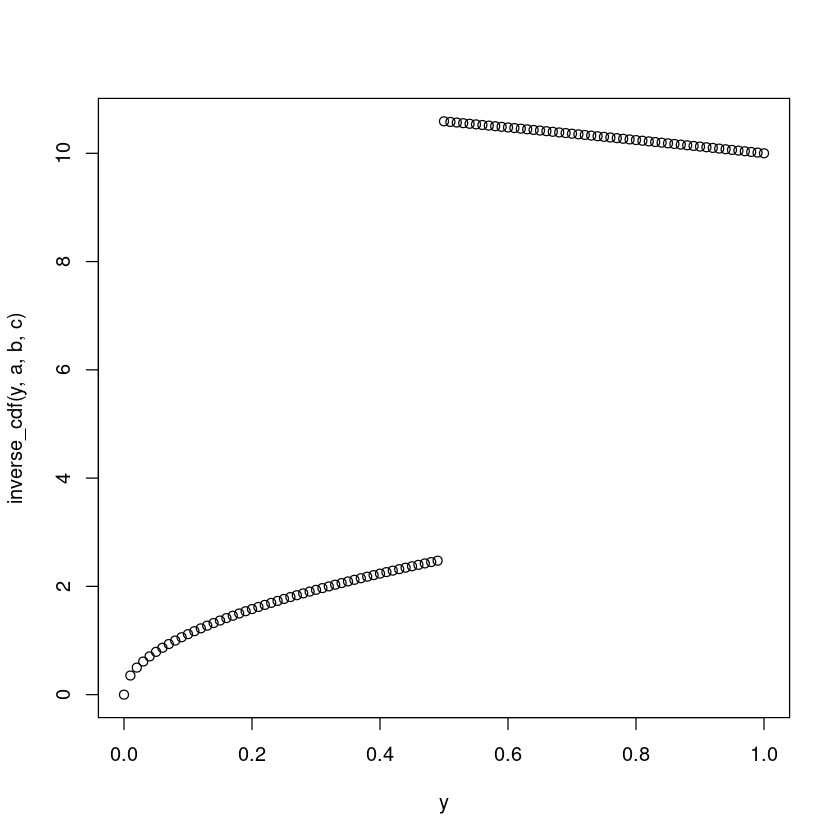

In [97]:
cdf_a <- triang_cdf(a,a,b,c)
cdf_c <- triang_cdf(c,a,b,c)
cdf_b <- triang_cdf(b,a,b,c)

inverse_cdf <- function(y, a,b,c){
    # if(y<0 & y>1){return("not valid input")}
    # cdf_a <- triang_cdf(a,a,b,c)
    # cdf_c <- triang_cdf(c,a,b,c)
    # cdf_b <- triang_cdf(b,a,b,c)
    A <- 2/((b-a)*(c-a)) 
    B <- 2/((b-a)*(b-c))
    C <- c^2 + 0.5*a^2 - a*c - b*c
    ifelse(y>=cdf_a & y<cdf_c, a + sqrt(2*y/A), 
    ifelse(y>= cdf_c & y<=cdf_b, (b + sqrt(2*b^2 + 2*C - 2*y/B)), 1)) 
}

y<- seq(0,1,0.01)
plot(y, inverse_cdf(y,a,b,c))
cdf_a
cdf_b
cdf_c


In [ ]:
# 1) extract a sample from U (0, 1)
samples <- runif(N)
# 2) compute F−1(u) = x

# 3) release x as sampled from our F(x)

## es2


In [52]:
# a) exponential
Mub <- function(E,k){
    return(E/k)
}

k <- 10

x <- seq(0,10,0.1)
lambda <- 1
esp <- pexp(x, lambda)
E_esp <- mean(esp)
Mub_esp <- Mub(E_esp, k)
espl_plot <- plot(esp, 1-)

